In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd '/gdrive/MyDrive/cs598ps-FP/FMA/'

/gdrive/.shortcut-targets-by-id/1ncfGTJoViDu8FhtUHbbIkR5-ANXXQuSl/cs598ps-FP/FMA


In [3]:
!pip install python-dotenv
# !pip install -U numpy
# !pip install torch torchvision

import os
import sys
import glob
import torch
import numpy as np
import pickle
from collections import Counter
import copy

import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch import nn

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import utils

print(torch.cuda.is_available())

True


In [4]:

# build dataset
class dataset(Dataset):
   def __init__(self, X, y):
        self.data = X
        self.labels = y
        
   def __len__(self):
        return len(self.labels)

   def __getitem__(self, index):
        return self.data[index], self.labels[index]

# build dataloaders
def build_dataloader(train_X, train_y, val_X, val_y, test_X, test_y):
  max_spec_len = max([s.shape[0] for s in train_X.to_numpy()])
  train_X = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[0]], value=0) for s in train_X.to_numpy()]).numpy()
  # train_X.shape
  test_X = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[0]], value=0) for s in test_X.to_numpy()]).numpy()
  val_X = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[0]], value=0) for s in val_X.to_numpy()]).numpy()


  # build label index
  lookupTable, indexed_dataSet = np.unique(train_y, return_inverse=True)
  train_y = indexed_dataSet
  # len(train_y)
  label2idx = {label: i for i, label in enumerate(lookupTable)}
  test_y = np.array([label2idx[l] for l in test_y])
  val_y = np.array([label2idx[l] for l in val_y])

  batch_size = 32

  train_loader = DataLoader(dataset(train_X, train_y), batch_size, shuffle=True)
  val_loader = DataLoader(dataset(val_X, val_y), batch_size, shuffle=True)
  test_loader = DataLoader(dataset(test_X, test_y), batch_size, shuffle=True)
  return train_loader, val_loader, test_loader

        

In [5]:
# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

print(tracks.shape, features_all.shape)

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']


Not enough Echonest features: (13129, 767)
(8000, 52) (8000, 518)


In [6]:
def evaluation(data, labels, method, n):
  if method == 'km':
    model = KMeans(n_clusters=n, random_state=0).fit(data)
    label = model.labels_
  else:
    model = GaussianMixture(n_components=n, random_state=21)
    label = model.fit_predict(data)

  playlists = {}
  for i, label in enumerate(label):
    if label in playlists:
      playlists[label].append(labels[i])
    else:
      playlists[label] = [labels[i]]

  score = []
  for pl in playlists.values():
    if len(pl) < 2:
      continue
    occurances = np.bincount(pl)
    max_occur = np.argmax(occurances)
    score.append(occurances[max_occur] / len(pl))
  return np.mean(score), playlists

def pre_process(tracks, features, columns):
  enc = LabelEncoder()
  labels = tracks['track', 'genre_top']

  # Split in training, validation and testing sets.
  y_train = enc.fit_transform(labels[train])
  y_val = enc.transform(labels[val])
  y_test = enc.transform(labels[test])
  X_train = features.loc[train, columns]
  X_val = features.loc[val, columns]
  X_test = features.loc[test, columns]
  
  X_train, y_train = shuffle(X_train, y_train, random_state=42)
  
  # Standardize features by removing the mean and scaling to unit variance.
  scaler = StandardScaler(copy=False)
  scaler.fit_transform(X_train)
  scaler.transform(X_val)
  scaler.transform(X_test)
  
  return y_train, y_val, y_test, X_train, X_val, X_test



In [7]:
def run_CNN(train_X, train_loader, val_loader, test_loader):
  epoch_num = 50
  batch_size = 32
  model = musicNet(train_X.shape[1], batch_size, hidden_dim=128, output_dim=8, num_layers=2).cuda()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  criterion = nn.CrossEntropyLoss()


  # training
  for epoch in range(epoch_num):
    # print("Epoch: %d"%epoch)
    model.train()
    # pbar = tqdm(train_loader, total=len(train_loader))
    vec_cnn_tr = []

    for X, y in train_loader:
      # assert False
      X = np.expand_dims(X, axis=1)
      X = torch.FloatTensor(X)
      y = torch.LongTensor(y)
      if torch.cuda.is_available():
          X, y = X.cuda(), y.cuda()
      # data, target = Variable(data), Variable(target)

      optimizer.zero_grad()
      logits = model(X)

      if epoch == epoch_num - 1:
        if len(vec_cnn_tr) == 0:
          vec_cnn_tr = logits.cpu().data.numpy()
        else:
          
          vec_cnn_tr = np.vstack((vec_cnn_tr, logits.cpu().data.numpy()))

      loss = criterion(logits, y)
      loss.backward()

      optimizer.step()


    # validation
    model.eval()
    # pbar = tqdm(val_loader, total=len(val_loader))
    preds = []
    targets = []
    
    for X, y in val_loader:
      X = np.expand_dims(X, axis=1)
      X = torch.FloatTensor(X)
      y = torch.LongTensor(y)
      if torch.cuda.is_available():
          X, y = X.cuda(), y.cuda()

      optimizer.zero_grad()
      logits = model(X)

      preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
      targets.extend(y.cpu())

      optimizer.step()
    # testing
  model.eval()
  # pbar = tqdm(test_loader, total=len(test_loader))
  preds = []
  targets = []
  vec_cnn_test = []
  for X, y in test_loader:
    X = np.expand_dims(X, axis=1)
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = model(X)

    if len(vec_cnn_test) == 0:
      vec_cnn_test = logits.cpu().data.numpy()
    else:
      vec_cnn_test = np.vstack((vec_cnn_test, logits.cpu().data.numpy()))

    preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
    targets.extend(y.cpu())

    optimizer.step()
  acc = sum(np.array(preds)==np.array(targets))/len(preds)
  return vec_cnn_tr, vec_cnn_test

class CNN(nn.Module):
    def __init__(self, input_dim):
        super(CNN, self).__init__()
        self.output_dim = 240
        self.conv1 = nn.Conv1d(1, 2, 50, stride=2)
        self.conv2 = nn.Conv1d(2, 4, 8, stride=1)
        self.conv2_drop = nn.Dropout()
        # self.fc1 = nn.Linear(self.output_dim, 50)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size = 2, stride=2))
        # x = self.conv1(x)
        # print(x.shape)
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), kernel_size = 2, stride=1)) # ([batchsize, channels, freq, time])
        b, c, f = x.shape
        # x = self.conv2_drop(self.conv2(x))

        # print('1', x.shape)
        

        x = x.view(x.shape[0], -1)
        x = x.unsqueeze(axis=1)

        # print('2', x.shape)
        # assert False

        # x = self.fc(x)

        # print(x.shape)

        # x = x.transpose(1, 3).reshape(b, t, -1) # ([batchsize, time, freq*channels])



        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, 0.2) # (batch_size, 1, )
        #x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x


class musicNet(nn.Module):
    def __init__(self, input_dim, batch_size, hidden_dim=128, output_dim=8, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.cnn = CNN(input_dim)

        # self.fc1 = nn.Linear(16 * 5 * 5, 120)

        self.rnn = nn.LSTM(self.cnn.output_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(128, output_dim)

        # self.optimizer = optim.Adam(self.parameters(), lr=0.0001)


    def forward(self, input):
        # print('inputshape: ', input.shape)
        batch_size, timesteps, T = input.size()
        X = input.view(batch_size * timesteps, 1, T)
        # print(X.shape)
        # todo: Add CNN here
        X = self.cnn(X) # input: (batch_size, 1, x*y) -> X: (batch_size, CNN_outdim)
        
        # print('3', X.shape)

        # # LSTM encoder, take last hidden state
        r_out, (h_n, h_c)  = self.rnn(X)
        h = h_n.view(self.num_layers, 2, batch_size, self.hidden_dim).sum(axis=1).mean(axis=0) # (batch, hidden)
        # # print(r_out.shape)
        # print('h', h.shape)
        logits = self.linear(h)

        # print(logits.shape)


        return logits

In [9]:
y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'])
train_loader, val_loader, test_loader = build_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)
predict_proba_train, predict_proba_test = run_CNN(X_train, train_loader, val_loader, test_loader)

n_comp_train = int(len(np.unique(predict_proba_train, axis=0))/10)
n_comp_test = int(len(np.unique(predict_proba_test, axis=0))/10)
train_km, pl1 = evaluation(predict_proba_train, y_train, 'km', n_comp_train)
train_gm, pl2 = evaluation(predict_proba_train, y_train, 'gm', n_comp_train)
test_km, pl3 = evaluation(predict_proba_test, y_test, 'km', n_comp_test)
test_gm, pl4 = evaluation(predict_proba_test, y_test, 'gm', n_comp_test)
print(X_train.shape[1], str([round(train_km, 4), round(train_gm, 4), round(test_km, 4), round(test_gm, 4)]))


322 [0.3227, 0.3278, 0.3141, 0.3097]


In [18]:
l = 0
p = []
for i in pl1.keys():
  if len(pl1[i]) > l:
    p = pl1[i]
    l = len(pl1[i])
print(p)

[3, 5, 6, 1, 7, 6, 6, 0, 1, 5, 4, 3, 5, 6, 5, 0, 1, 0, 5, 1, 2, 4, 0, 5]


In [19]:
d = {}
for i in p:
  if i in d:
    d[i] += 1
  else:
    d[i] = 1

print(d)

{3: 2, 5: 6, 6: 4, 1: 4, 7: 1, 0: 4, 4: 2, 2: 1}


In [20]:
def eval(fset):
  y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset)
  train_loader, val_loader, test_loader = build_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)
  predict_proba_train, predict_proba_test = run_CNN(X_train, train_loader, val_loader, test_loader)
  
  n_comp_train = int(len(np.unique(predict_proba_train, axis=0))/10)
  n_comp_test = int(len(np.unique(predict_proba_test, axis=0))/10)
  train_km, _ = evaluation(predict_proba_train, y_train, 'km', n_comp_train)
  train_gm, _ = evaluation(predict_proba_train, y_train, 'gm', n_comp_train)
  test_km, _ = evaluation(predict_proba_test, y_test, 'km', n_comp_test)
  test_gm, _ = evaluation(predict_proba_test, y_test, 'gm', n_comp_test)
  print(X_train.shape[1], str([round(train_km, 4), round(train_gm, 4), round(test_km, 4), round(test_gm, 4)]))


In [21]:
def accy(fset):
  y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset)
  train_loader, val_loader, test_loader = build_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)

  accy = run_CNN(X_train, train_loader, val_loader, test_loader)
  print(accy)

In [29]:
eval(['mfcc'])

140 [0.3299, 0.3242, 0.3236, 0.3247]


In [31]:
eval(['mfcc', 'spectral_contrast'])

189 [0.3114, 0.3161, 0.3167, 0.3227]


In [33]:
eval(['mfcc', 'spectral_contrast', 'spectral_centroid'])

196 [0.3146, 0.3211, 0.317, 0.3091]


In [37]:
eval(['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'])

280 [0.313, 0.3176, 0.3286, 0.3119]


In [39]:
eval(['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'])

322 [0.3154, 0.3197, 0.3123, 0.3142]


In [22]:
eval(['mfcc'])
eval(['mfcc', 'spectral_contrast'])
eval(['mfcc', 'spectral_contrast', 'spectral_centroid'])
eval(['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'])
eval(['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'])

140 [0.338, 0.3372, 0.3299, 0.3143]
189 [0.3311, 0.3262, 0.3393, 0.3066]
196 [0.3373, 0.3367, 0.3343, 0.3304]
280 [0.3321, 0.3246, 0.3384, 0.3033]
322 [0.3293, 0.3267, 0.3215, 0.3157]


In [ ]:
# Directory where mp3 are stored.
AUDIO_DIR = '/gdrive/MyDrive/cs598ps-FP/FMA/fma_small'
# checkpoint dir
checkpoint_dir = '/gdrive/MyDrive/cs598ps-FP/FMA/checkpoint'

tx = pickle.load(open(checkpoint_dir + '/training_x', "rb"))
ty = pickle.load(open(checkpoint_dir + '/training_y', "rb"))
tsx = pickle.load(open(checkpoint_dir + '/test_x', "rb"))
tsy = pickle.load(open(checkpoint_dir + '/test_y', "rb"))
vx = pickle.load(open(checkpoint_dir + '/validation_x', "rb"))
vy = pickle.load(open(checkpoint_dir + '/validation_y', "rb"))
print(len(tx), len(ty), len(tsx), len(tsy), len(vx), len(vy))
print(len(tx) + len(tsx) + len(vx))

6310 6310 787 787 800 800
7897


In [ ]:
# check shapes
# print(tx[0].shape)
# print(tx[1].shape)
# print(tx[2].shape)
# print(ty[0])

# pad to maxlen
max_spec_len = max([s.shape[-1] for s in tx])
train_X2 = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[-1], 0, 0], value=0) for s in tx]).numpy()
# train_X.shape
test_X2 = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[-1], 0, 0], value=0) for s in tsx]).numpy()
val_X2 = torch.stack([F.pad(input=torch.tensor(s), pad=[0,  max_spec_len - s.shape[-1], 0, 0], value=0) for s in vx]).numpy()


# build label index
lookupTable, indexed_dataSet = np.unique(ty, return_inverse=True)
train_y2 = indexed_dataSet
# len(train_y)
label2idx = {label: i for i, label in enumerate(lookupTable)}
test_y2 = np.array([label2idx[l] for l in tsy])
val_y2 = np.array([label2idx[l] for l in vy])


In [ ]:
# define model

# standard CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.output_dim = 7672
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(2, 50), stride=(1, 5))
        self.conv2 = nn.Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
        self.conv2_drop = nn.Dropout2d()
        # self.fc = nn.Linear(self.output_dim, 256)

        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 2, stride=2))
        # x = self.conv1(x)
        # print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size = 2, stride=1)) # ([batchsize, channels, freq, time])
        b, c, f, t = x.shape
        # x = self.conv2_drop(self.conv2(x))

        # print(x.shape)
        

        x = x.view(x.shape[0], -1)
        x = x.unsqueeze(axis=1)

        # print(x.shape)
        # assert False

        # x = self.fc(x)

        # print(x.shape)

        # x = x.transpose(1, 3).reshape(b, t, -1) # ([batchsize, time, freq*channels])



        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, 0.2) # (batch_size, 1, )
        #x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x



class musicNet(nn.Module):
    def __init__(self, input_dim, batch_size, hidden_dim=128, output_dim=8, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # self.conv1 = nn.Conv2d(3, 6, 5)
        
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.conv2_bn = nn.BatchNorm2d(16)

        self.cnn = CNN()

        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        self.rnn = nn.LSTM(self.cnn.output_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)
        
        # self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=self.cnn.output_dim, nhead=8, dim_feedforward=self.hidden_dim), num_layers=self.num_layers)
        # self.fc_t = nn.Linear(self.cnn.output_dim, self.hidden_dim)


        self.linear = nn.Linear(self.hidden_dim, output_dim)

        # self.optimizer = optim.Adam(self.parameters(), lr=0.0001)


    def forward(self, input):
        # print(input.shape)
        batch_size, timesteps, T, S = input.size()
        X = input.view(batch_size * timesteps, 1, T, S)

        # todo: Add CNN here
        X = self.cnn(X) # input: (batch_size, time, x*y) -> X: (batch_size, time, CNN_outdim)


        # print(X.shape)

        # LSTM encoder, take last hidden state
        r_out, (h_n, h_c)  = self.rnn(X)
        h = h_n.view(self.num_layers, 2, batch_size, self.hidden_dim).sum(axis=1).mean(axis=0) # (batch, hidden)

        # transformer 
        # X = X.transpose(0, 1)
        # t_out = self.transformer(X)
        # h = t_out.transpose(0, 1).squeeze(1)
        # h = self.fc_t(h)
        # print(t_out.shape)
        # assert False


        # print(r_out.shape)

        logits = self.linear(h)

        # todo:
        

        # since we use nn.CrossEntropyLoss, we can skip the final activation function as it is already implemented
        # genre_scores = F.log_softmax(logits, dim=1)


        # return genre_scores

        return logits


In [ ]:
epoch_num = 10
batch_size = 4
model = musicNet(train_X[0].shape[0:], batch_size, hidden_dim=128, output_dim=8, num_layers=2).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# training
best_acc = 0.
vec_stdcnn_tr = []
for epoch in range(epoch_num):
  print("Epoch: %d"%epoch)
  model.train()
  pbar = tqdm(train_loader, total=len(train_loader))
  
  for X, y in pbar:
    
    # assert False
    X = np.expand_dims(X, axis=1)
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # data, target = Variable(data), Variable(target)

    optimizer.zero_grad()
    logits = model(X)
    if epoch == epoch_num - 1:
      if len(vec_stdcnn_tr) == 0:
        vec_stdcnn_tr = logits.cpu().data.numpy()
      else:
        vec_stdcnn_tr = np.vstack((vec_stdcnn_tr, logits.cpu().data.numpy()))

    loss = criterion(logits, y)
    loss.backward()

    optimizer.step()

    pbar.set_description("loss: %.3f" %loss.item())


  # validation
  model.eval()
  pbar = tqdm(val_loader, total=len(val_loader))
  preds = []
  targets = []
  for X, y in pbar:
    X = np.expand_dims(X, axis=1)
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = model(X)

    preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
    targets.extend(y.cpu())

    optimizer.step()

  acc = sum(np.array(preds)==np.array(targets))/len(preds)
  print("val acc: %.3f"%(acc))
  
  if best_acc < acc:
    best_acc = acc
    best_model = copy.deepcopy(model)
  

Epoch: 0


KeyboardInterrupt: ignored

In [ ]:
# testing
best_model.eval()
pbar = tqdm(test_loader, total=len(test_loader))
preds = []
targets = []
vec_stdcnn_test = []
for X, y in pbar:
  X = np.expand_dims(X, axis=1)
  X = torch.FloatTensor(X)
  y = torch.LongTensor(y)
  if torch.cuda.is_available():
      X, y = X.cuda(), y.cuda()

  optimizer.zero_grad()
  logits = best_model(X)

  if len(vec_stdcnn_test) == 0:
    vec_stdcnn_test = logits.cpu().data.numpy()
  else:
    vec_stdcnn_test = np.vstack((vec_stdcnn_test, logits.cpu().data.numpy()))

  preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
  targets.extend(y.cpu())

  optimizer.step()

print("test acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



test acc: 0.260


In [ ]:
max(indexed_dataSet)

In [ ]:
# baselines

## Baseline 
random select

In [ ]:
# random select
pbar = tqdm(test_loader, total=len(test_loader))
preds = []
targets = []
for X, y in pbar:
  targets.extend(y)

preds = np.random.randint(max(indexed_dataSet) + 1, size=len(targets))
print("random select acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))


random select acc: 0.122


## Vanilla CNN

In [11]:
# Vanilla CNN
# define model

# standard CNN
class vCNN(nn.Module):
    def __init__(self, input_dim):
        super(vCNN, self).__init__()
        self.output_dim = int(np.ceil((int(np.ceil((input_dim-50)/4)) - 8)/2)) * 4
        self.conv1 = nn.Conv1d(1, 2, 50, stride=2)
        self.conv2 = nn.Conv1d(2, 4, 8, stride=1)
        self.conv2_drop = nn.Dropout()
        self.fc1 = nn.Linear(self.output_dim, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # print(self.output_dim)
        # print(x.shape)
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        # print(x.shape)
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 2))
        # print(x.shape)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2) # (batch_size, 1, )
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x



class vmusicNet(nn.Module):
    def __init__(self, input_dim, batch_size, hidden_dim=128, output_dim=8, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # self.conv1 = nn.Conv2d(3, 6, 5)
        
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.conv2_bn = nn.BatchNorm2d(16)

        self.cnn = vCNN(input_dim)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # self.rnn = nn.LSTM(self.cnn.output_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(10, output_dim)

        # self.optimizer = optim.Adam(self.parameters(), lr=0.0001)


    def forward(self, input):
        # print('inputshape: ', input.shape)
        batch_size, timesteps, T = input.size()
        X = input.view(batch_size * timesteps, 1, T)

        # todo: Add CNN here
        X = self.cnn(X) # input: (batch_size, 1, x*y) -> X: (batch_size, CNN_outdim)
        
        # print(X.shape)

        # # LSTM encoder, take last hidden state
        # r_out, (h_n, h_c)  = self.rnn(X)
        # h = h_n.view(self.num_layers, 2, batch_size, self.hidden_dim).sum(axis=1).mean(axis=0) # (batch, hidden)
        # # print(r_out.shape)

        logits = self.linear(X)

        # print(logits.shape)


        return logits




0.33

In [ ]:
"train_loader = DataLoader(dataset(train_X2, train_y2), 4, shuffle=True)
val_loader = DataLoader(dataset(val_X2, val_y2), 4, shuffle=True)
test_loader = DataLoader(dataset(test_X2, test_y2), 4, shuffle=True)

In [ ]:
epoch_num = 10
batch_size = 4
model = vmusicNet(train_X2[0].shape[0:], batch_size, hidden_dim=128, output_dim=8, num_layers=2).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


# training
for epoch in range(epoch_num):
  print("Epoch: %d"%epoch)
  model.train()
  pbar = tqdm(train_loader, total=len(train_loader))
  vec_vcnn_tr = []
  for X, y in pbar:

    # assert False
    X = np.expand_dims(X, axis=1)
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # data, target = Variable(data), Variable(target)

    optimizer.zero_grad()
    logits = model(X)

    if epoch == epoch_num - 1:
      if len(vec_vcnn_tr) == 0:
        vec_vcnn_tr = logits.cpu().data.numpy()
      else:
        vec_vcnn_tr = np.vstack((vec_vcnn_tr, logits.cpu().data.numpy()))

    loss = criterion(logits, y)
    loss.backward()

    optimizer.step()

    pbar.set_description("loss: %.3f" %loss.item())
    break
  break

  # validation
  model.eval()
  pbar = tqdm(val_loader, total=len(val_loader))
  preds = []
  targets = []
  
  for X, y in pbar:
    X = np.expand_dims(X, axis=1)
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = model(X)

    preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
    targets.extend(y.cpu())

    optimizer.step()

  print("val acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))
  
  

Epoch: 0


inputshape:  torch.Size([4, 1, 20, 2812])
torch.Size([4, 1, 20, 2812])
torch.Size([4, 5, 9, 1381])
torch.Size([4, 10, 4, 666])
torch.Size([4, 26640])
torch.Size([4, 10])


In [ ]:
# testing
model.eval()
pbar = tqdm(test_loader, total=len(test_loader))
preds = []
targets = []
vec_vcnn_test = []
for X, y in pbar:
  X = np.expand_dims(X, axis=1)
  X = torch.FloatTensor(X)
  y = torch.LongTensor(y)
  if torch.cuda.is_available():
      X, y = X.cuda(), y.cuda()

  optimizer.zero_grad()
  logits = model(X)

  if len(vec_vcnn_test) == 0:
    vec_vcnn_test = logits.cpu().data.numpy()
  else:
    vec_vcnn_test = np.vstack((vec_vcnn_test, logits.cpu().data.numpy()))

  preds.extend(F.log_softmax(logits, dim=0).argmax(axis=1).cpu())
  targets.extend(y.cpu())

  optimizer.step()

print("test acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))

In [ ]:
def evaluation(data, loader, method, n):
  if method == 'km':
    model = KMeans(n_clusters=n, random_state=0).fit(data)
    label = model.labels_
  else:
    model = GaussianMixture(n_components=n, random_state=21)
    label = model.fit_predict(data)

  playlists = {}
  for i, label in enumerate(label):
    if label in playlists:
      playlists[label].append(loader.dataset.labels[i])
    else:
      playlists[label] = [loader.dataset.labels[i]]

  score = []
  for pl in playlists.values():
    if len(pl) < 2:
      continue
    occurances = np.bincount(pl)
    max_occur = np.argmax(occurances)
    score.append(occurances[max_occur] / len(pl))
  return np.mean(score), playlists

vec_vcnn_km, vec_vcnn_km_pl = evaluation(vec_vcnn_tr, train_loader, 'km', 1000)
vec_vcnn_gm, vec_vcnn_gm_pl = evaluation(vec_vcnn_tr, train_loader, 'gm', 1000)
vec_vcnnte_km, vec_vcnnte_km_pl = evaluation(vec_vcnn_test, test_loader, 'km', 130)
vec_vcnnte_gm, vec_vcnnte_gm_pl = evaluation(vec_vcnn_test, test_loader, 'gm', 130)
print(vec_vcnn_km)
print(vec_vcnn_gm)
print(vec_vcnnte_km)
print(vec_vcnnte_gm)

In [ ]:
train_X.reshape(train_X.shape[0], -1).shape

(6310, 56240)

In [ ]:
# KNN 

from sklearn.neighbors import KNeighborsClassifier


neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(train_X.reshape(train_X.shape[0], -1), train_y)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:


preds = neigh.predict(test_X.reshape(test_X.shape[0], -1))

targets = test_y
print("test acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))


test acc: 0.155


In [ ]:
# KNN + PCA (+ tsne)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

neigh = KNeighborsClassifier(n_neighbors=5)
pca = PCA(n_components=20)
pca.fit(train_X[:1000, :, :].reshape(train_X[:1000, :, :].shape[0], -1))
projected_train = pca.fit_transform(train_X[:1000, :, :].reshape(train_X[:1000, :, :].shape[0], -1))
projected_test = pca.transform(test_X.reshape(test_X.shape[0], -1))


In [ ]:
preds = neigh.predict(projected_test)

targets = test_y
print("test acc: %.3f"%(sum(np.array(preds)==np.array(targets))/len(preds)))


test acc: 0.216


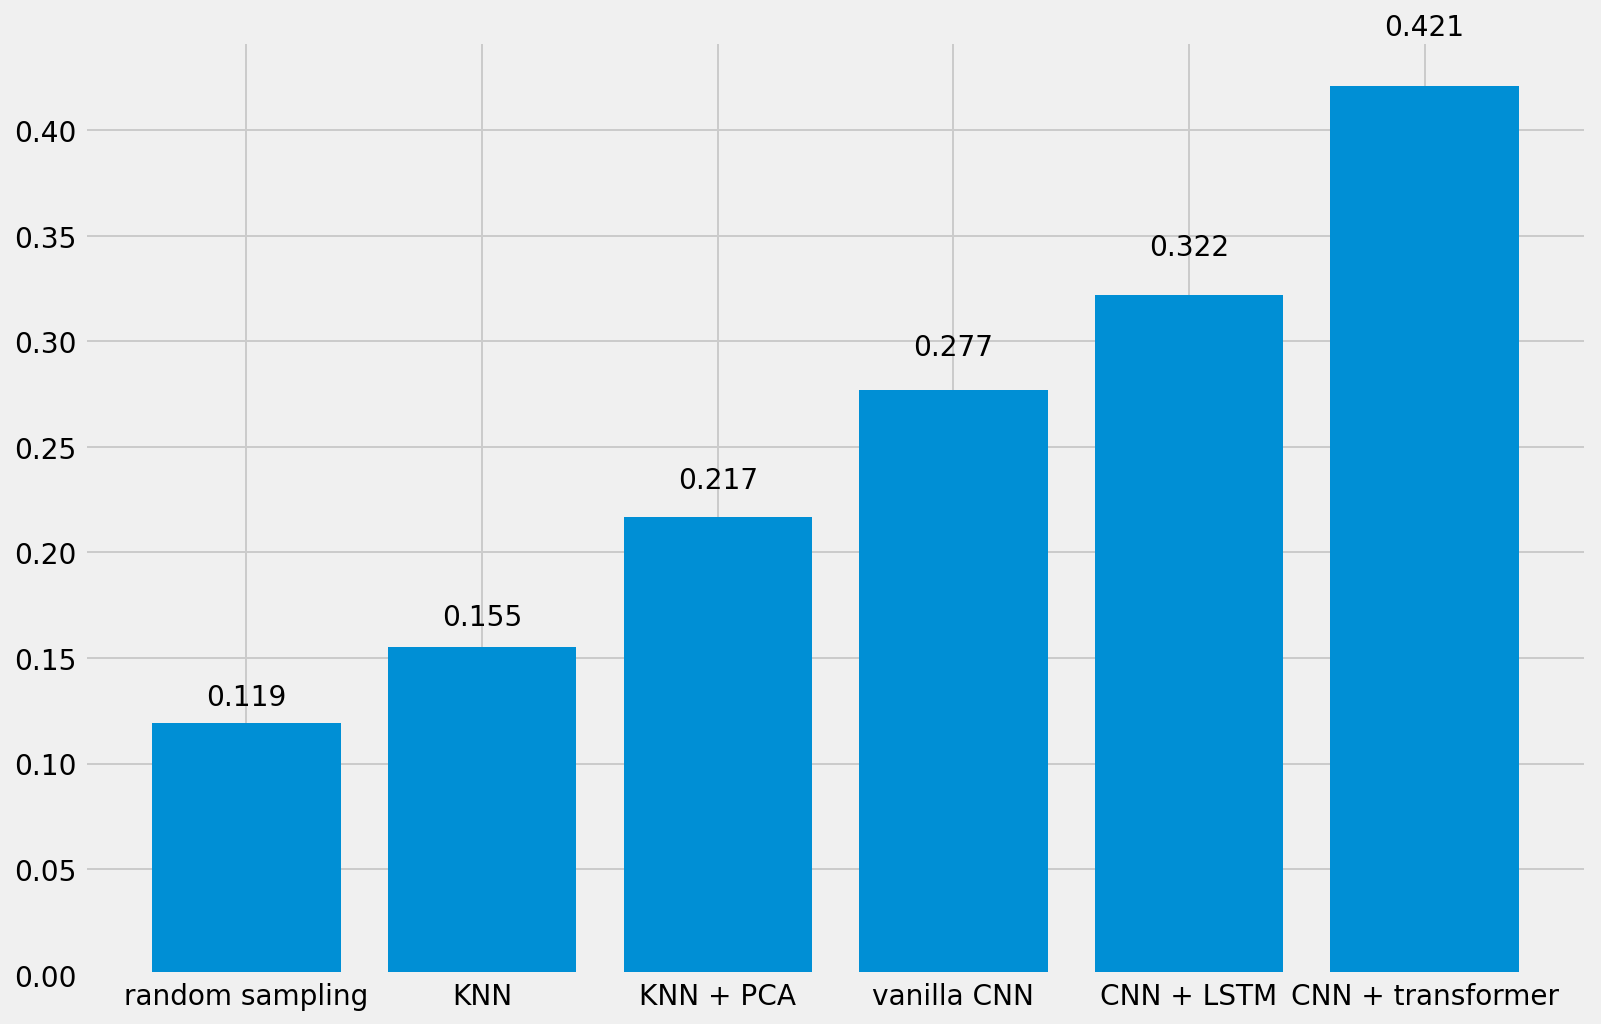

In [ ]:
# make plot with experiment results
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
%config InlineBackend.figure_format='retina'

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

results = {
    'random sampling':  0.119,
    'KNN': 0.155,
    'KNN + PCA': 0.217,
    'vanilla CNN': 0.277,
    'CNN + LSTM': 0.322,
    'CNN + transformer': 0.421,
    # 'CNN + transformer + attention-pooling': 0,
}


with plt.style.context('fivethirtyeight'):
  fig, ax = plt.subplots(figsize=(12, 8))
  rects1 = ax.bar(results.keys(), results.values())
  autolabel(rects1)


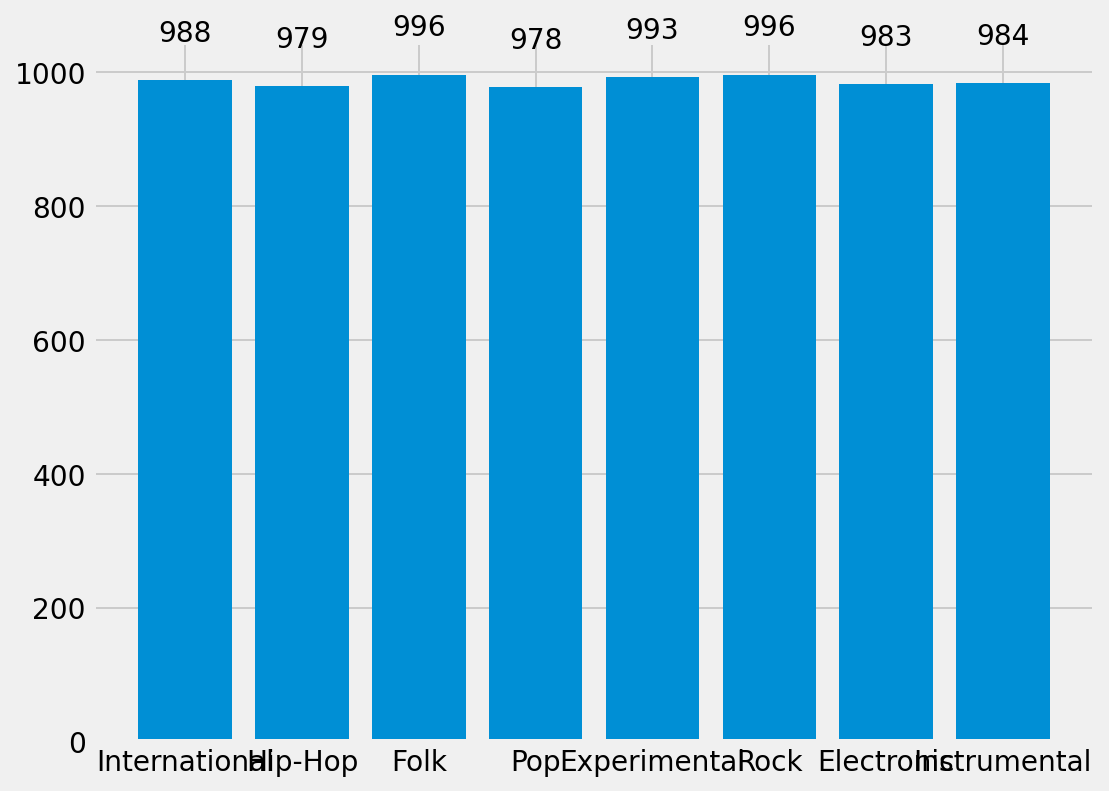

In [ ]:
# dataset description
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % height,
                ha='center', va='bottom')



c = Counter(ty) + Counter(tsy) + Counter(vy)

with plt.style.context('fivethirtyeight'):
  fig, ax = plt.subplots(figsize=(8, 6))
  rects1 = ax.bar(c.keys(), c.values())
  autolabel(rects1)


In [ ]:
# PCA + t-sne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca.fit(train_X[:500, :, :].reshape(train_X[:500, :, :].shape[0], -1))
projected = pca.fit_transform(train_X[:500, :, :].reshape(train_X[:500, :, :].shape[0], -1))


In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(projected)

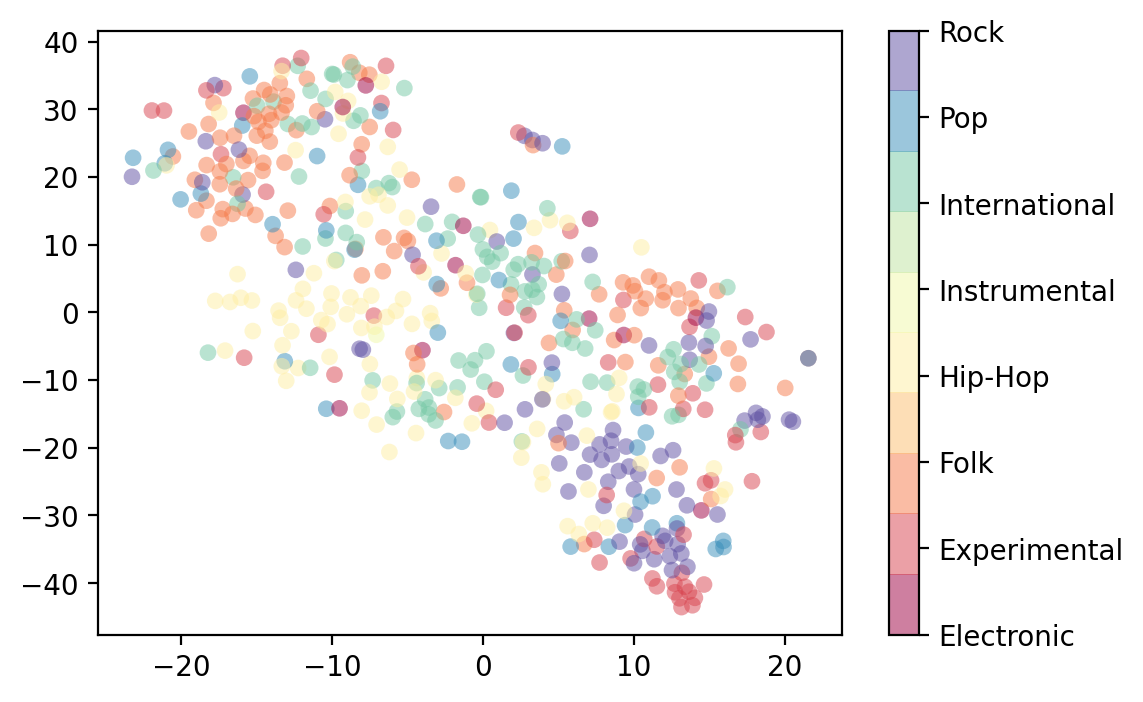

In [ ]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(dpi=100)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=train_y[:500], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
cb = plt.colorbar()
cb.set_ticks(np.arange(len(lookupTable)))
cb.set_ticklabels(lookupTable)

In [ ]:
classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'NB': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
}

# use the following features:
# mfcc+contrast
# mfcc+contrast+centroid
# mfcc+contrast+centroid+chroma
# mfcc+contrast+centroid+chroma+tonnetz


In [ ]:
scores = test_classifiers_features(classifiers, feature_sets)
print(scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                                         dim  ...                               QDA
mfcc                                   140.0  ...  [0.6575, 0.6559, 0.5264, 0.5036]
mfcc/contrast                          189.0  ...  [0.7411, 0.7657, 0.5549, 0.5351]
mfcc/contrast/centroid                 196.0  ...  [0.7416, 0.7298, 0.4951, 0.4871]
mfcc/contrast/chroma/centroid          280.0  ...  [0.9701, 0.8842, 0.5233, 0.5137]
mfcc/contrast/chroma/centroid/tonnetz  322.0  ...  [0.9581, 0.9861, 0.5128, 0.5001]

[5 rows x 5 columns]


In [ ]:
ipd.display(scores)

,dim,LR,kNN,NB,QDA
mfcc,140.0,"[0.5525, 0.5522, 0.5077, 0.5083]","[0.6221, 0.5399, 0.4171, 0.3857]","[0.5209, 0.5118, 0.5199, 0.4896]","[0.6575, 0.6559, 0.5264, 0.5036]"
mfcc/contrast,189.0,"[0.5868, 0.5843, 0.5123, 0.5256]","[0.6207, 0.4795, 0.4317, 0.4193]","[0.5266, 0.5279, 0.5636, 0.5568]","[0.7411, 0.7657, 0.5549, 0.5351]"
mfcc/contrast/centroid,196.0,"[0.5906, 0.5902, 0.5267, 0.5253]","[0.6415, 0.5232, 0.4455, 0.3995]","[0.5371, 0.5334, 0.5601, 0.5238]","[0.7416, 0.7298, 0.4951, 0.4871]"
mfcc/contrast/chroma/centroid,280.0,"[0.5992, 0.6073, 0.5228, 0.5006]","[0.641, 0.5282, 0.4278, 0.3934]","[0.5327, 0.5324, 0.512, 0.487]","[0.9701, 0.8842, 0.5233, 0.5137]"
mfcc/contrast/chroma/centroid/tonnetz,322.0,"[0.6211, 0.6175, 0.4985, 0.492]","[0.6408, 0.5206, 0.4186, 0.4288]","[0.5373, 0.543, 0.5312, 0.4858]","[0.9581, 0.9861, 0.5128, 0.5001]"


In [ ]:
def test_classifiers_features(classifiers, feature_sets):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    for fset_name, fset in tqdm(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
    return scores


In [ ]:
scores = test_classifiers_features(classifiers, feature_sets)
print(scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                                         dim       LR  ...       NB      QDA
mfcc                                   140.0  0.42125  ...  0.36000  0.39500
mfcc/contrast                          189.0  0.43250  ...  0.39500  0.40750
mfcc/contrast/centroid                 196.0  0.43250  ...  0.39625  0.40750
mfcc/contrast/chroma/centroid          280.0  0.43375  ...  0.38500  0.41625
mfcc/contrast/chroma/centroid/tonnetz  322.0  0.42875  ...  0.41000  0.40375

[5 rows x 5 columns]


In [ ]:
ipd.display(scores)

,dim,LR,kNN,NB,QDA
mfcc,140.0,0.42125,0.34875,0.36000,0.39500
mfcc/contrast,189.0,0.43250,0.36125,0.39500,0.40750
mfcc/contrast/centroid,196.0,0.43250,0.35125,0.39625,0.40750
mfcc/contrast/chroma/centroid,280.0,0.43375,0.34250,0.38500,0.41625
mfcc/contrast/chroma/centroid/tonnetz,322.0,0.42875,0.33625,0.41000,0.40375


In [ ]:
def KNN_PCA(train_X, test_X, train_y, test_y):
  neigh = KNeighborsClassifier(n_neighbors=5)
  pca = PCA(n_components=20)
  pca.fit(train_X)
  projected_train = pca.fit_transform(train_X)
  projected_test = pca.transform(test_X)
  neigh.fit(projected_train, train_y)

  return neigh.score(projected_test, test_y)

In [ ]:
scores = test_classifiers_features2(feature_sets)
print(scores)


                                         dim   knnpca
mfcc                                   140.0  0.35875
mfcc/contrast                          189.0  0.35750
mfcc/contrast/centroid                 196.0  0.34250
mfcc/contrast/chroma/centroid          280.0  0.30875
mfcc/contrast/chroma/centroid/tonnetz  322.0  0.33500
